In [69]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import imageio
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11001912039868184522
]


In [70]:
"""
Build Joint Stream Graph (from i3d.py)
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'



imagenet_pretrained = True # use pretrained model as it had better performance
eval_type = "joint" # build the graph for both streams 
tf.reset_default_graph() # reset graph each time cell is run, prevents duplicate variables

if eval_type not in ['rgb', 'flow', 'joint']:
    raise ValueError('Bad `eval_type`, must be one of rgb, flow, joint')

kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]

if eval_type in ['rgb', 'joint']:
    # RGB input has 3 channels.
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
    with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
    rgb_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'RGB':
            rgb_variable_map[variable.name.replace(':0', '')] = variable
    rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

if eval_type in ['flow', 'joint']:
    # Flow input has only 2 channels.
    flow_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 2))
    with tf.variable_scope('Flow'):
        flow_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        flow_logits, _ = flow_model(
            flow_input, is_training=False, dropout_keep_prob=1.0)
    flow_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'Flow':
            flow_variable_map[variable.name.replace(':0', '')] = variable
    flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

if eval_type == 'rgb':
    model_logits = rgb_logits
elif eval_type == 'flow':
    model_logits = flow_logits
else:
    model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)

In [71]:
"""
Run sample (playing cricket) prediction with joint
"""
eval_type = "joint"
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        # print("feed_dict", feed_dict)
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)

        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
INFO:tensorflow:Restoring parameters from data/checkpoints/flow_imagenet/model.ckpt
INFO:tensorflow:Flow checkpoint restored
flow size: (1, 79, 224, 224, 2)
INFO:tensorflow:Flow data loaded, shape=(1, 79, 224, 224, 2)
Norm of logits: 138.468658

Top classes and probabilities
1.0 41.813675 playing cricket
1.4971563e-09 21.493977 hurling (sport)
3.8431164e-10 20.134108 catching or throwing baseball
1.5492331e-10 19.225584 catching or throwing softball
1.13601656e-10 18.915352 hitting baseball
8.801122e-11 18.660118 playing tennis
2.4415652e-11 17.377878 playing kickball
1.1531949e-11 16.627775 playing squash or racquetball
6.131936e-12 15.996164 shooting goal (soccer)
4.391769e-12 15.662386 hammer throw
2.21341e-12 14.977189 golf putting
1.6307157e-12 14.671673 throwing discus


In [86]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    start = time.time()
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    print("Blur time", time.time()-start)
    return X


def create_flow_image(X):
        return np.append(X + 0.5, 0.5 * np.ones((224, 224, 1)), axis=2)


def save_gif(X, class_name, stream_type):
    # save all frames
    num_frames = X.shape[1]
    print("shape", X.shape)
    directory = "experiments_{}/{}/".format(stream_type, class_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    image_name = "{}_{}".format(class_name, stream_type)
    file_name = directory + image_name + "{}.png"
    print("file_name", file_name)
    filenames = []
    for i in range(0, num_frames):
        if stream_type == "rgb":
            plt.imshow(X[0][i])
        elif stream_type == "flow":
            print("chna", X[0][i].shape)
            plt.imshow(create_flow_image(X[0][i]))
        
        filename = file_name.format(i)
        filenames.append(filename)
        plt.savefig(filename.format(i))
        # plt.show()
    
    #create gif
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
        imageio.mimsave(directory + "/{}".format(image_name) + ".gif", images)

In [88]:
def create_class_visualization(sess, rgb_input, flow_input, target_y, logits, class_name, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    print("params", kwargs)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 4)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    num_frames = kwargs.pop('num_frames', 25)
    stream_type = kwargs.pop('stream_type', 'rgb')
    
    # X = np.random.rand(num_frames, 224, 224, 3)
    if stream_type == 'rgb':
        stream_input = rgb_input
        X = np.random.rand(1, 224, 224, 3) * np.ones((num_frames, 224, 224, 3))
        X = X[None]
    elif stream_type == 'flow':
        stream_input = flow_input
        X = np.random.rand(1, 224, 224, 2)
        # preprocess as described in paper
        X = X - .5
        X = X[None]
    
    loss = logits[0, target_y] # scalar loss

    grad = tf.gradients(loss, stream_input) # compute gradient
    grad = tf.squeeze(grad) - l2_reg*2*stream_input # regualarlize gradient

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        # we want logits for loss, model.classifier are just logits
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        gradient_step = sess.run(grad, feed_dict={stream_input:X})
        X += learning_rate * gradient_step

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        #X = np.clip(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=1)
        
        print("iteration:", t, time.time()-start_time)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            
            if stream_type == "rgb":
                plt.imshow(X[0][0])
            elif stream_type == "flow":
                plt.imshow(create_flow_image(X[0][0]))
          
            if t == num_iterations-1:
                save_gif(X, class_name, stream_type)
                    
            plt.title('{}_{}\nIteration {} / {}'.format(class_name, stream_type, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

Tensor("add:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
abseiling
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
params {'stream_type': 'rgb', 'num_frames': 1, 'num_iterations': 1, 'learning_rate': 1.5, 'blur_every': 3, 'max_jitter': 32}
Blur time 0.008852005004882812
iteration: 0 5.183847904205322
file_name experiments_rgb/abseilingtest/abseilingtest_rgb{}.png


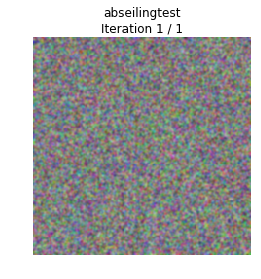

In [78]:
"""
Run RGB visualization only
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(model_logits)
print(rgb_input)
target = 0
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/cpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        create_class_visualization(sess, rgb_input, flow_input, target, rgb_logits, action_name + "test", stream_type='rgb', num_frames=1, num_iterations=1, learning_rate=1.5, blur_every=3, max_jitter=32)

Tensor("add:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder_1:0", shape=(1, ?, 224, 224, 2), dtype=float32)
abseiling
INFO:tensorflow:Restoring parameters from data/checkpoints/flow_imagenet/model.ckpt
params {'stream_type': 'flow', 'num_frames': 1, 'num_iterations': 1, 'learning_rate': 1.5, 'blur_every': 3, 'max_jitter': 32}
Blur time 0.006028652191162109
iteration: 0 5.272442102432251
shape (1, 1, 224, 224, 2)
file_name experiments_flow/abseilingtest/abseilingtest_flow{}.png
chna (224, 224, 2)


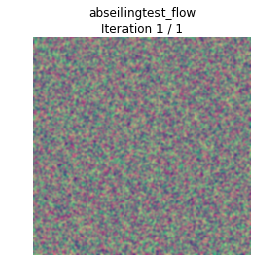

In [89]:
"""
Run FLOW visualization only
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(model_logits)
print(flow_input)
target = 0
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/cpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
        create_class_visualization(sess, rgb_input, flow_input, target, flow_logits, action_name + "test", stream_type='flow', num_frames=1, num_iterations=1, learning_rate=1.5, blur_every=3, max_jitter=32)